# Análise e Modelagem Cinemática de uma Perna de Robô Hexápode

Notebook criado para estudo, análise e validação dos tópicos abordados no meu TCC.

### Autor: Luís Paulo Furtuna A. Junior

In [2]:
import numpy as np
import sympy as sp #SymPy is a Python library for symbolic mathematics.
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Cálculos matriciais Denavit-Hutenberg

Parâmetros Denavit-Hutenberg

$\theta_i$ = rotação em torno do eixo zi-1

$d_i$ = translação ao longo do eixo zi-1

$a_i$ = translação ao longo do eixo xi

$\alpha_i$ = rotação em torno do eixo xi

Parametros dos elos do robô hexapode

| i | $\theta_i$ | $d_i$ | $a_i$ | $\alpha_i$      |
| - | ---------- | ----- | ----- | --------------- |
| 1 | $\theta_1$ | 0     | $L_1$ | $\frac{\pi}{2}$ |
| 2 | $\theta_2$ | 0     | $L_2$ | 0               |
| 3 | $\theta_3$ | 0     | $L_3$ | 0               |



### 📐 Matriz Geral de Denavit-Hartenberg

A matriz de transformação homogênea entre os frames $i-1$ e $i$, usando os parâmetros DH, é dada por:

$$
T_i^{i-1} =
\begin{bmatrix}
\cos\theta_i & -\sin\theta_i \cos\alpha_i & \sin\theta_i \sin\alpha_i & a_i \cos\theta_i \\
\sin\theta_i & \cos\theta_i \cos\alpha_i & -\cos\theta_i \sin\alpha_i & a_i \sin\theta_i \\
0 & \sin\alpha_i & \cos\alpha_i & d_i \\
0 & 0 & 0 & 1
\end{bmatrix}
$$


A perna do robô hexápode tem 3 juntas( coxa, fêmur, tíbia), e usando método DH, então:

* Cada junta tem uma matriz $T_i^{i-1}$
* Multiplicando todas: você obtém a **posição final do pé da perna** no sistema base.

$$ T_3^{0} = T_1^{0} * T_2^{1} * T_3^{2} $$




In [3]:
# Define variáveis simbólicas
theta1, theta2, theta3 = sp.symbols('theta1 theta2 theta3')
L1, L2, L3 = sp.symbols('L1 L2 L3')

# Matriz T1
T1 = sp.Matrix([
    [sp.cos(theta1), 0, sp.sin(theta1), L1*sp.cos(theta1)],
    [sp.sin(theta1), 0, -sp.cos(theta1), L1*sp.sin(theta1)],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])

# Matriz T1
T2 = sp.Matrix([
    [sp.cos(theta2), -sp.sin(theta2), 0, L2*sp.cos(theta2)],
    [sp.sin(theta2), sp.cos(theta2), 0, L2*sp.sin(theta2)],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Matriz T3
T3 = sp.Matrix([
    [sp.cos(theta3), -sp.sin(theta3), 0, L3*sp.cos(theta3)],
    [sp.sin(theta3), sp.cos(theta3), 0, L3*sp.sin(theta3)],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Multiplicação total
T_total = T1 * T2 * T3
T_total.simplify()

T_total

Matrix([
[cos(theta1)*cos(theta2 + theta3), -sin(theta2 + theta3)*cos(theta1),  sin(theta1), (L1 + L2*cos(theta2) + L3*cos(theta2 + theta3))*cos(theta1)],
[sin(theta1)*cos(theta2 + theta3), -sin(theta1)*sin(theta2 + theta3), -cos(theta1), (L1 + L2*cos(theta2) + L3*cos(theta2 + theta3))*sin(theta1)],
[            sin(theta2 + theta3),              cos(theta2 + theta3),            0,                    L2*sin(theta2) + L3*sin(theta2 + theta3)],
[                               0,                                 0,            0,                                                           1]])

## Configurando valores de $\theta_1$,$\theta_2$ e $\theta_3$


In [4]:
theta1, theta2, theta3 = 0, 0, 0  # Ângulos em graus


## Função python para cinemática direta

In [5]:
def cinematica_direta(theta1, theta2, theta3, a1=29, a2=76, a3=106):
    """
    Calcula a cinemática direta de uma pata 3DOF de um hexápode Lynxmotion.
    Entrada:
        theta1, theta2, theta3: Ângulos das juntas em graus.
        a1, a2, a3: Comprimentos dos elos em mm (coxa, fêmur, tíbia).
    Saída:
        (x, y, z): Coordenadas do efetuador em mm.
    """
    # Converter ângulos para radianos
    th1 = np.radians(theta1)
    th2 = np.radians(theta2)
    th3 = np.radians(theta3)

    # Calcular posição
    x = np.cos(th1) * (a1 + a2 * np.cos(th2) + a3 * np.cos(th2 + th3))
    y = np.sin(th1) * (a1 + a2 * np.cos(th2) + a3 * np.cos(th2 + th3))
    z = a2 * np.sin(th2) + a3 * np.sin(th2 + th3)

    return x, y, z

In [6]:
# Exemplo de uso
#theta1, theta2, theta3 = 0, 90, 0  # Ângulos em graus
x, y, z = cinematica_direta(theta1, theta2, theta3)
print(f"Posição do efetuador: x={x:.2f} mm, y={y:.2f} mm, z={z:.2f} mm")

Posição do efetuador: x=211.00 mm, y=0.00 mm, z=0.00 mm


# Simulação pata

In [26]:


def plot_pata_3dof(theta1, theta2, theta3, elev=30, azim=135, a1=28.48, a2=76.20, a3=103.36):
    """
    Plota a pata 3DOF de um hexápode Lynxmotion em 3D usando Matplotlib.
    """
    # Converter ângulos para radianos
    th1 = np.radians(theta1)
    th2 = np.radians(theta2)
    th3 = np.radians(theta3)

    # Calcular posições das juntas
    p0 = np.array([0, 0, 0])

    p1 = np.array([
        a1 * np.cos(th1),
        a1 * np.sin(th1),
        0
    ])

    p2 = p1 + np.array([
        a2 * np.cos(th1) * np.cos(th2),
        a2 * np.sin(th1) * np.cos(th2),
        a2 * np.sin(th2)
    ])

    p3 = p2 + np.array([
        a3 * np.cos(th1) * np.cos(th2 + th3),
        a3 * np.sin(th1) * np.cos(th2 + th3),
        a3 * np.sin(th2 + th3)
    ])

    # Plotagem
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    points = np.array([p0, p1, p2, p3])
    ax.plot(points[:, 0], points[:, 1], points[:, 2], 'b-', linewidth=2, label='Elos')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='red', s=100, label='Juntas')

    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title(f'Pata 3DOF: θ1={theta1}°, θ2={theta2}°, θ3={theta3}°\n XYZ = ({p3[0]:.2f}, {p3[1]:.2f}, {p3[2]:.2f})')
    print(f'Pata 3DOF:({theta1},{theta2},{theta3})\n XYZ = ({p3[0]:.2f}, {p3[1]:.2f}, {p3[2]:.2f})')

    max_range = max(a1 + a2 + a3, np.max(np.abs(points))) * 1.2
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])

    ax.legend()
    ax.set_box_aspect([1, 1, 1])  # Deixa os eixos proporcionais
    # Eixos coordenados globais (X, Y, Z)
    eixo_len = 150  # comprimento das setas dos eixos

    ax.quiver(0, 0, 0, eixo_len, 0, 0, color='red', linestyle='-', label='Eixo X')
    ax.quiver(0, 0, 0, 0, eixo_len, 0, color='green', linestyle='-', label='Eixo Y')
    ax.quiver(0, 0, 0, 0, 0, eixo_len, color='blue', linestyle='-', label='Eixo Z')

    # Rotulando os eixos
    ax.text(eixo_len, 0, 0, 'X', color='red', fontsize=12)
    ax.text(0, eixo_len, 0, 'Y', color='green', fontsize=12)
    ax.text(0, 0, eixo_len, 'Z', color='blue', fontsize=12)

    ax.view_init(elev=elev, azim=azim)

    plt.show()

# Interface interativa
interact(
    plot_pata_3dof,
    theta1=FloatSlider(min=-180, max=180, step=1, value=30, description='θ1 (°)'),
    theta2=FloatSlider(min=-90, max=90, step=1, value=30, description='θ2 (°)'),
    theta3=FloatSlider(min=-130, max=90, step=1, value=-90, description='θ3 (°)'),
    elev=FloatSlider(min=-90, max=90, step=1, value=30, description='Elevação'),
    azim=FloatSlider(min=0, max=360, step=1, value=135, description='Azimute')
);

interactive(children=(FloatSlider(value=30.0, description='θ1 (°)', max=180.0, min=-180.0, step=1.0), FloatSli…

In [27]:
def plot_pata_3dof_with_views(theta1, theta2, theta3,a1=28.48, a2=76.20, a3=103.36):
    # Conversão para radianos
    th1 = np.radians(theta1)
    th2 = np.radians(theta2)
    th3 = np.radians(theta3)

    # Posições das juntas
    p0 = np.array([0, 0, 0])

    p1 = np.array([
        a1 * np.cos(th1),
        a1 * np.sin(th1),
        0
    ])

    p2 = p1 + np.array([
        a2 * np.cos(th1) * np.cos(th2),
        a2 * np.sin(th1) * np.cos(th2),
        a2 * np.sin(th2)
    ])

    p3 = p2 + np.array([
        a3 * np.cos(th1) * np.cos(th2 + th3),
        a3 * np.sin(th1) * np.cos(th2 + th3),
        a3 * np.sin(th2 + th3)
    ])

    points = np.array([p0, p1, p2, p3])

    # Plotagem: criar 3 subplots (1x3)
    fig = plt.figure(figsize=(18, 6))

    # === Gráfico 3D ===
    ax3d = fig.add_subplot(131, projection='3d')
    ax3d.plot(points[:, 0], points[:, 1], points[:, 2], 'b-', linewidth=2, label='Elos')
    ax3d.scatter(points[:, 0], points[:, 1], points[:, 2], c='red', s=60, label='Juntas')
    ax3d.set_xlabel('X (mm)')
    ax3d.set_ylabel('Y (mm)')
    ax3d.set_zlabel('Z (mm)')
    ax3d.set_title('Vista 3D')
    max_range = max(a1 + a2 + a3, np.max(np.abs(points))) * 1.2
    ax3d.set_xlim([-max_range, max_range])
    ax3d.set_ylim([-max_range, max_range])
    ax3d.set_zlim([-max_range, max_range])
    ax3d.legend()
    ax3d.set_box_aspect([1, 1, 1])

    # === Vista Superior (XY) ===
    ax_top = fig.add_subplot(132)
    ax_top.plot(points[:, 0], points[:, 1], 'b-o', linewidth=2, markersize=6)
    ax_top.set_xlabel('X (mm)')
    ax_top.set_ylabel('Y (mm)')
    ax_top.set_title('Vista Superior (XY)')
    ax_top.set_xlim([-max_range, max_range])
    ax_top.set_ylim([-max_range, max_range])
    ax_top.grid(True)
    ax_top.set_aspect('equal')

    # === Vista Lateral (XZ) ===
    ax_side = fig.add_subplot(133)
    ax_side.plot(points[:, 0], points[:, 2], 'b-o', linewidth=2, markersize=6)
    ax_side.set_xlabel('X (mm)')
    ax_side.set_ylabel('Z (mm)')
    ax_side.set_title('Vista Lateral (XZ)')
    ax_side.set_xlim([-max_range, max_range])
    ax_side.set_ylim([-max_range, max_range])
    ax_side.grid(True)
    ax_side.set_aspect('equal')


    plt.tight_layout()
    plt.show()


# Interface interativa no notebook
interact(
    plot_pata_3dof_with_views,
    theta1=FloatSlider(min=-180, max=180, step=1, value=30, description='θ1 (°)'),
    theta2=FloatSlider(min=-90, max=90, step=1, value=30, description='θ2 (°)'),
    theta3=FloatSlider(min=-90, max=90, step=1, value=-90, description='θ3 (°)')
);

interactive(children=(FloatSlider(value=30.0, description='θ1 (°)', max=180.0, min=-180.0, step=1.0), FloatSli…

# Método Geométrico

In [9]:
def cinematica_inversa(x, y, z, a1=28.48, a2=76.20, a3=103.36):
    """
    Calcula a cinemática inversa de uma pata 3DOF de um hexápode Lynxmotion.
    Entrada:
        x, y, z: Coordenadas do efetuador em mm.
        a1, a2, a3: Comprimentos dos elos em mm (coxa, fêmur, tíbia).
    Saída:
        (theta1, theta2, theta3): Ângulos das juntas em graus, ou None se fora do alcance.
    """
    # Calcular theta1
    theta1 = np.arctan2(y, x)

    # Calcular x' e z'
    x_prime = x * np.cos(theta1) + y * np.sin(theta1) - a1
    z_prime = z

    # Calcular k e r
    k = x_prime**2 + z_prime**2 + a2**2 - a3**2
    r = np.sqrt(x_prime**2 + z_prime**2)

    if r == 0 or abs(k / (2 * a2 * r)) > 1:
        return None  # Posição fora do alcance

    # Calcular theta2 (duas soluções)
    phi = np.arctan2(z_prime, x_prime)
    cos_arg = k / (2 * a2 * r)
    theta2_1 = phi + np.arccos(cos_arg)
    theta2_2 = phi - np.arccos(cos_arg)

    # Função para calcular theta3 dado theta2
    def get_theta3(x_prime, z_prime, theta2, a2, a3):
        cos_sum = (x_prime - a2 * np.cos(theta2)) / a3
        sin_sum = (z_prime - a2 * np.sin(theta2)) / a3
        return np.arctan2(sin_sum, cos_sum) - theta2

    # Calcular theta3 para ambas as soluções
    theta3_1 = get_theta3(x_prime, z_prime, theta2_1, a2, a3)
    theta3_2 = get_theta3(x_prime, z_prime, theta2_2, a2, a3)

    # Converter para graus
    solutions = [
        (np.degrees(theta1), np.degrees(theta2_1), np.degrees(theta3_1)),
        (np.degrees(theta1), np.degrees(theta2_2), np.degrees(theta3_2))
    ]

    return solutions

In [10]:
# Exemplo de uso
#x, y, z = theta1, theta2, theta3
#print(x,y,z)
solutions = cinematica_inversa(130.99, 113.87, 23.87)
if solutions:
    for i, (th1, th2, th3) in enumerate(solutions):
        print(f"({th1:.2f},{th2:.2f},{th3:.2f})")
        #print(f"Solução {i+1}: theta1={th1:.2f}°, theta2={th2:.2f}°, theta3={th3:.2f}°")
else:
    print("Nenhuma solução válida encontrada.")

(41.00,51.00,-71.00)
(41.00,-32.31,71.00)


# Método Algébrico 1

In [11]:
import numpy as np

def calculate_thetas2(x0, y0, z0,L1=28.48, L2=76.20, L3=103.36):
    # Calculate theta1
    theta1 = np.arctan2(y0, x0)
    J = (x0/np.cos(theta1)) - L1
    A = -2*J*L2
    B = -2*L2*z0
    C = J**2 + z0**2 -L3**2 +L2**2
    theta2_1 = np.arctan2((-B*C) + np.sqrt((B**2)*(C**2)-(A**2 + B**2)*(C**2-A**2)),-A*C + np.sqrt((A**2)*(C**2)-(A**2 + B**2)*(C**2-B**2)))
    theta2_2 = np.arctan2((-B*C) - (np.sqrt((B**2)*(C**2)-(A**2 + B**2)*(C**2-A**2))),-A*C-np.sqrt((A**2)*(C**2)-(A**2 + B**2)*(C**2-B**2)))
    return np.degrees(theta1),theta2_1,theta2_2

def calculate_thetas3(x0, y0, z0,t21,t22, L1=28.48, L2=76.20, L3=103.36):
    # Calculate theta1
    theta1 = np.arctan2(y0, x0)
    A = L3*np.sin(t21)
    B = L3*np.cos(t21)
    C = L2*np.sin(t21) - z0
    theta3_1 = np.arctan2(-B*C + np.sqrt((B**2)*(C**2)-(A**2 + B**2)*(C**2-A**2)),-A*C+np.sqrt((A**2)*(C**2)-(A**2 + B**2)*(C**2-B**2)))

    A = L3*np.sin(t22)
    B = L3*np.cos(t22)
    C = L2*np.sin(t22) - z0
    theta3_2 = np.arctan2(-B*C - np.sqrt((B**2)*(C**2)-(A**2 + B**2)*(C**2-A**2)),-A*C-np.sqrt((A**2)*(C**2)-(A**2 + B**2)*(C**2-B**2)))

    return np.degrees(theta3_1),np.degrees(theta3_2)
a,b,c = (208.04, 0.00, 0.00)
t1,t21,t22 = calculate_thetas2(a,b,c)
t31,t32 = calculate_thetas3(a,b,c,t21,t22)
t21,t22 = np.degrees(t21),np.degrees(t22)
solutions = [(t1,t21,t31),(t1,t22,t32)]
if solutions:
 for i, (th1, th2, th3) in enumerate(solutions):
        #print(f"Solução {i+1}: theta1={th1:.2f}°, theta2={th2:.2f}°, theta3={th3:.2f}°")
        print(f"({th1:.2f},{th2:.2f},{th3:.2f})")

(0.00,0.00,0.00)
(0.00,0.00,-180.00)


# Método Algébrico 1 - com substituição da tangente do meio ângulo

In [12]:
import numpy as np

def calculate_thetas2(x0, y0, z0, L1=28.48, L2=76.20, L3=103.36):
    # Calcula theta1
    theta1 = np.arctan2(y0, x0)
    J = (x0 / np.cos(theta1)) - L1

    # Coeficiente para eq trigonometrica
    A = -2 * J * L2
    B = -2 * L2 * z0
    C = J**2 + z0**2 - L3**2 + L2**2

    # coeficientes novos
    a = C - A
    b = 2 * B
    c = A + C

    # Resolver eq quadratica para t = tan(theta2/2)
    discriminant = b**2 - 4 * a * c
    if discriminant < 0:
        return np.degrees(theta1), np.nan, np.nan  # sem solução real

    t1 = (-b + np.sqrt(discriminant)) / (2 * a)
    t2 = (-b - np.sqrt(discriminant)) / (2 * a)

    # Calculate theta2 from t
    theta2_1 = 2 * np.arctan(t1)
    theta2_2 = 2 * np.arctan(t2)

    return np.degrees(theta1), np.degrees(theta2_1), np.degrees(theta2_2)

def calculate_thetas3(x0, y0, z0, t21, t22, L1=28.48, L2=76.20, L3=103.36):
    # Convere t21 e t22 para radians se estão em graus
    t21_rad = np.radians(t21) if not np.isnan(t21) else t21
    t22_rad = np.radians(t22) if not np.isnan(t22) else t22

    # Coeficientes para theta3_1
    A1 = L3 * np.sin(t21_rad)
    B1 = L3 * np.cos(t21_rad)
    C1 = L2 * np.sin(t21_rad) - z0

    # Coeficientes novos para theta3_1
    a1 = C1 - A1
    b1 = 2 * B1
    c1 = A1 + C1

    # Resolver equação quadrática para t = tan(theta3_1/2)
    discriminant1 = b1**2 - 4 * a1 * c1
    if discriminant1 < 0:
        theta3_1 = np.nan
    else:
        t1 = (-b1 + np.sqrt(discriminant1)) / (2 * a1)
        theta3_1 = 2 * np.arctan(t1)

    # Coeficientes para theta3_2
    A2 = L3 * np.sin(t22_rad)
    B2 = L3 * np.cos(t22_rad)
    C2 = L2 * np.sin(t22_rad) - z0

    # Coeficientes novos para theta3_2
    a2 = C2 - A2
    b2 = 2 * B2
    c2 = A2 + C2

    # Resolver equação quadrática para t = tan(theta3_2/2)
    discriminant2 = b2**2 - 4 * a2 * c2
    if discriminant2 < 0:
        theta3_2 = np.nan
    else:
        t2 = (-b2 - np.sqrt(discriminant2)) / (2 * a2)
        theta3_2 = 2 * np.arctan(t2)

    return np.degrees(theta3_1), np.degrees(theta3_2)

# Teste com os valores fornecidos
a, b, c = (135.45, -91.37, -118.417)
t1, t21, t22 = calculate_thetas2(a, b, c)
t31, t32 = calculate_thetas3(a, b, c, t21, t22)  # t21, t22 já estão em graus
solutions = [(t1, t21, t31), (t1, t22, t32)]

if solutions:
    for i, (th1, th2, th3) in enumerate(solutions):
        print(f"Solução {i+1}: ({th1:.2f}, {th2:.2f}, {th3:.2f})")

Solução 1: (-34.00, -39.64, -2.85)
Solução 2: (-34.00, -42.91, -97.02)


# Método Algébrico 2


In [13]:
import numpy as np

def calculate_thetas2(x0, y0, z0,L1=28.48, L2=76.20, L3=103.36):
    # Calcula theta1
    theta1 = np.arctan2(y0, x0)
    J = (x0/np.cos(theta1)) - L1
    A = -2*J*L2
    B = -2*L2*z0
    C = J**2 + z0**2 -L3**2 +L2**2
    theta2_1 = np.arctan2((-B*C) + np.sqrt((B**2)*(C**2)-(A**2 + B**2)*(C**2-A**2)),-A*C + np.sqrt((A**2)*(C**2)-(A**2 + B**2)*(C**2-B**2)))
    theta2_2 = np.arctan2((-B*C) - (np.sqrt((B**2)*(C**2)-(A**2 + B**2)*(C**2-A**2))),-A*C-np.sqrt((A**2)*(C**2)-(A**2 + B**2)*(C**2-B**2)))
    return np.degrees(theta1),theta2_1,theta2_2

def calculate_thetas3(x0, y0, z0,t21,t22, L1=28.48, L2=76.20, L3=103.36):
    theta3_1 = np.arcsin((z0-L2*np.sin(t21))/L3) -t21
    theta3_2 = np.arcsin((z0-L2*np.sin(t22))/L3) -t22
    return np.degrees(theta3_1),np.degrees(theta3_2)

a,b,c = (130.99, 113.87, 23.87)
t1,t21,t22 = calculate_thetas2(a,b,c)
t31,t32 = calculate_thetas3(a,b,c,t21,t22)
t21,t22 = np.degrees(t21),np.degrees(t22)
solutions = [(t1,t21,t31),(t1,t22,t32)]
if solutions:
 for i, (th1, th2, th3) in enumerate(solutions):
        #print(f"Solução {i+1}: theta1={th1:.2f}°, theta2={th2:.2f}°, theta3={th3:.2f}°")
        print(f"({th1:.2f},{th2:.2f},{th3:.2f})")

(41.00,42.60,-58.15)
(41.00,-40.34,85.43)


# Método Algébrico 2 - com substituição da tangente do meio ângulo

In [14]:
import numpy as np

def calculate_thetas2(x0, y0, z0, L1=28.48, L2=76.20, L3=103.36):
    # Calcula theta1
    theta1 = np.arctan2(y0, x0)
    J = (x0 / np.cos(theta1)) - L1

    # coeficientes da equação trigonométrica
    A = -2 * J * L2
    B = -2 * L2 * z0
    C = J**2 + z0**2 - L3**2 + L2**2

    # Novos coefiientes
    a = C - A
    b = 2 * B
    c = A + C

    # Resolver equação quadrática para t = tan(theta2/2)
    discriminant = b**2 - 4 * a * c
    if discriminant < 0:
        return np.degrees(theta1), np.nan, np.nan

    t1 = (-b + np.sqrt(discriminant)) / (2 * a)
    t2 = (-b - np.sqrt(discriminant)) / (2 * a)

    # Calcula theta2 de t
    theta2_1 = 2 * np.arctan(t1)
    theta2_2 = 2 * np.arctan(t2)

    return np.degrees(theta1), np.degrees(theta2_1), np.degrees(theta2_2)

def calculate_thetas3(x0, y0, z0, t21, t22, L1=28.48, L2=76.20, L3=103.36):
    theta3_1 = np.arcsin((z0 - L2 * np.sin(t21)) / L3) - t21
    theta3_2 = np.arcsin((z0 - L2 * np.sin(t22)) / L3) - t22
    return np.degrees(theta3_1), np.degrees(theta3_2)

# Teste com os valores fornecidos
a, b, c = (135.45, -91.37, -118.417)
t1, t21, t22 = calculate_thetas2(a, b, c)
t31, t32 = calculate_thetas3(a, b, c, np.radians(t21), np.radians(t22))  # Convertendo t21, t22 para radianos
solutions = [(t1, t21, t31), (t1, t22, t32)]

if solutions:
    for i, (th1, th2, th3) in enumerate(solutions):
        print(f"Solução {i+1}: ({th1:.2f}, {th2:.2f}, {th3:.2f})")

Solução 1: (-34.00, -39.64, -2.85)
Solução 2: (-34.00, -42.91, 2.85)


# Posicionamento patas pelo corpo

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# --- Cinemática direta da perna ---
def cinematica_direta_pata(theta1, theta2, theta3, a1=2.848, a2=7.620, a3=10.336):
    th1 = np.radians(theta1)
    th2 = np.radians(theta2)
    th3 = np.radians(theta3)

    p0 = np.array([0, 0, 0])
    p1 = np.array([a1 * np.cos(th1), a1 * np.sin(th1), 0])
    p2 = p1 + np.array([
        a2 * np.cos(th1) * np.cos(th2),
        a2 * np.sin(th1) * np.cos(th2),
        a2 * np.sin(th2)
    ])
    p3 = p2 + np.array([
        a3 * np.cos(th1) * np.cos(th2 + th3),
        a3 * np.sin(th1) * np.cos(th2 + th3),
        a3 * np.sin(th2 + th3)
    ])

    return np.array([p0, p1, p2, p3])

# --- Plotagem completa: 3D + XY ---
def plot_hexapode_com_xy(theta1=0, theta2=45, theta3=-60, elev=30, azim=135):
    base_positions = [
        (5.06, -8.76, 0),
        (6.99, 0.00, 0),
        (5.06, 8.76, 0),
        (-5.06, 8.76, 0),
        (-6.99, 0.00, 0),
        (-5.06, -8.76, 0)
    ]
    phi_deg = [-60.0, 0.0, 60.0, 120.0, 180.0, -120.0]
    phi_rad = np.radians(phi_deg)

    fig = plt.figure(figsize=(14, 6))

    # Subplot 3D
    ax3d = fig.add_subplot(121, projection='3d')
    foot_positions = []

    for i in range(6):
        points = cinematica_direta_pata(theta1, theta2, theta3)
        R = np.array([
            [np.cos(phi_rad[i]), -np.sin(phi_rad[i]), 0],
            [np.sin(phi_rad[i]),  np.cos(phi_rad[i]), 0],
            [0, 0, 1]
        ])
        transformed = (R @ points.T).T + np.array(base_positions[i])
        foot_positions.append(transformed[-1])  # ponto final da pata

        ax3d.plot(transformed[:, 0], transformed[:, 1], transformed[:, 2], 'b-', linewidth=2)
        ax3d.scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2], c='red', s=50)

    ax3d.scatter([0], [0], [0], c='green', s=100, label='Centro do corpo')
    ax3d.set_title(f'Hexápode 3D - θ₁={theta1}°, θ₂={theta2}°, θ₃={theta3}°')
    ax3d.set_xlabel("X (cm)")
    ax3d.set_ylabel("Y (cm)")
    ax3d.set_zlabel("Z (cm)")
    ax3d.set_box_aspect([1, 1, 1])
    ax3d.view_init(elev=elev, azim=azim)
    L = 25
    ax3d.set_xlim([-L, L])
    ax3d.set_ylim([-L, L])
    ax3d.set_zlim([-L, L])
    ax3d.legend()

    # Subplot XY (vista de cima)
    axxy = fig.add_subplot(122)
    axxy.set_title("Visão XY dos Pés")
    axxy.set_xlabel("X (cm)")
    axxy.set_ylabel("Y (cm)")
    axxy.set_xlim(-L, L)
    axxy.set_ylim(-L, L)
    axxy.set_aspect('equal')
    axxy.grid(True)

    for i, foot in enumerate(foot_positions):
        x, y, z = foot[0], foot[1], foot[2]
        axxy.plot(x, y, 'ro')
        axxy.text(x + 0.5, y + 0.5, f'{i+1} ({x:.1f}, {y:.1f}, {z:.1f})', fontsize=9)


    axxy.plot(0, 0, 'go', label="Centro do corpo")
    axxy.legend()
    plt.tight_layout()
    plt.show()

# --- Interface interativa ---
interact(
    plot_hexapode_com_xy,
    theta1=FloatSlider(min=-180, max=180, step=1, value=0, description='θ₁ (°)'),
    theta2=FloatSlider(min=-90, max=90, step=1, value=45, description='θ₂ (°)'),
    theta3=FloatSlider(min=-150, max=0, step=1, value=-60, description='θ₃ (°)'),
    elev=FloatSlider(min=-90, max=90, step=1, value=30, description='Elevação'),
    azim=FloatSlider(min=0, max=360, step=1, value=135, description='Azimute')
);


interactive(children=(FloatSlider(value=0.0, description='θ₁ (°)', max=180.0, min=-180.0, step=1.0), FloatSlid…

# Trajetória

In [19]:
def plot_multiplas_patas(lista_xyz, a1=28.48, a2=76.20, a3=103.36, elev=35, azim=20):
    """
    Plota múltiplas patas no mesmo gráfico 3D com cor única (preto) e eixos proporcionais.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for idx, (x, y, z) in enumerate(lista_xyz):
        solutions = cinematica_inversa(x, y, z, a1, a2, a3)

        if solutions is None:
            print(f"[{idx}] Coordenada ({x}, {y}, {z}) está fora do alcance.")
            continue

        theta1, theta2, theta3 = solutions[0]
        th1 = np.radians(theta1)
        th2 = np.radians(theta2)
        th3 = np.radians(theta3)

        # Cinemática direta
        p0 = np.array([0, 0, 0])
        p1 = np.array([
            a1 * np.cos(th1),
            a1 * np.sin(th1),
            0
        ])
        p2 = p1 + np.array([
            a2 * np.cos(th1) * np.cos(th2),
            a2 * np.sin(th1) * np.cos(th2),
            a2 * np.sin(th2)
        ])
        p3 = p2 + np.array([
            a3 * np.cos(th1) * np.cos(th2 + th3),
            a3 * np.sin(th1) * np.cos(th2 + th3),
            a3 * np.sin(th2 + th3)
        ])

        # Plotar elos e juntas (em preto)
        pontos = np.array([p0, p1, p2, p3])
        ax.plot(pontos[:, 0], pontos[:, 1], pontos[:, 2], color='black', linewidth=2)
        ax.scatter(pontos[:, 0], pontos[:, 1], pontos[:, 2], color='black', s=60)

        #print(f"Pata {idx}: (x, y, z) = ({x}, {y}, {z})")
        #print(f"  → Ângulos: θ1 = {theta1:.2f}°, θ2 = {theta2:.2f}°, θ3 = {theta3:.2f}°")
        #print(f"  → Posição final (cinemática direta): {p3}")

    # Eixos coordenados globais (reduzidos)
    eixo_len = 50
    ax.quiver(0, 0, 0, eixo_len, 0, 0, color='red')
    ax.quiver(0, 0, 0, 0, eixo_len, 0, color='green')
    ax.quiver(0, 0, 0, 0, 0, eixo_len, color='blue')
    ax.text(eixo_len, 0, 0, 'X', color='red')
    ax.text(0, eixo_len, 0, 'Y', color='green')
    ax.text(0, 0, eixo_len, 'Z', color='blue')

    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title('Visualização passo - Hexápode 3DOF')
    ax.view_init(elev=elev, azim=azim)
    ax.set_box_aspect([1, 1, 1])
    plt.show()


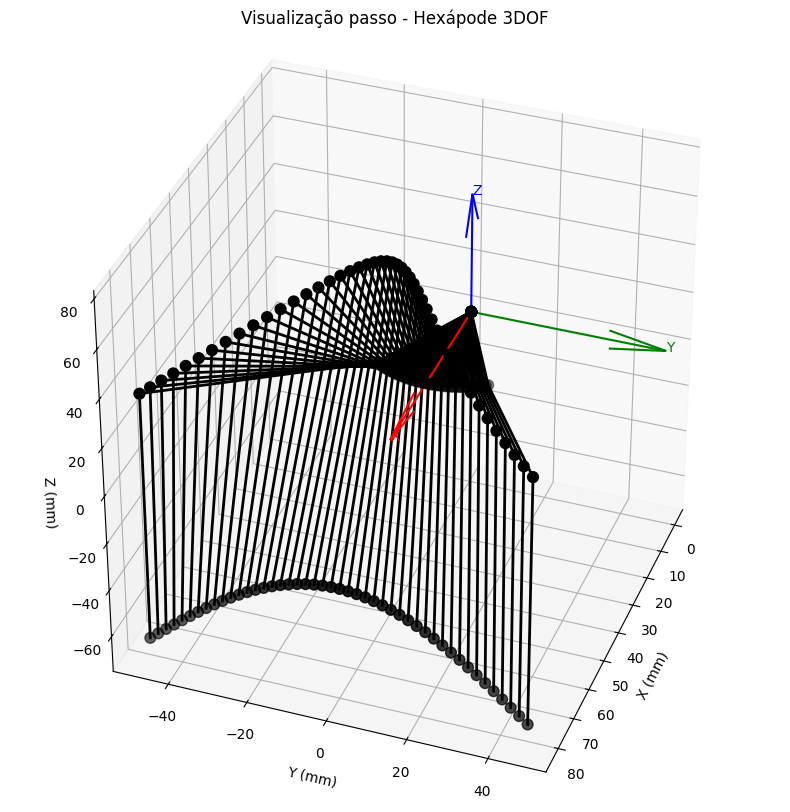

In [20]:
import math

def get_points(A, B, step=2):
    """
    Retorna uma lista de pontos (x, y, z) para phi de 0 a 90 graus, a cada 'step' graus.

    Parâmetros:
    - A: Amplitude da oscilação em x
    - B: Amplitude da oscilação em z
    - step: Intervalo em graus entre os pontos (padrão é 5)

    Retorna:
    - Lista de tuplas (x, y, z)
    """
    points = []
    x0 = 81.81
    y0 = 47.24
    z0 = -65.26
    m = -188.96 / math.pi

    for phi_deg in range(0, 91, step):
        phi_rad = math.radians(phi_deg)
        x = x0 + A * math.sin(2 * phi_rad)
        y = y0 + m * phi_rad
        z = z0 + B * math.sin(2 * phi_rad)
        points.append((x, y, z))

    return points
# Lista de posições finais desejadas (uma por pata)
coordenadas = [
    (100, 50, -50),
    (100, -50, -50),
    (120, 0, -70),
    (90, 60, -40),
    (85, -60, -45),
    (95, 0, -60)
]

plot_multiplas_patas(get_points(0, 40))



In [21]:
def animar_patas(lista_xyz, a1=28.48, a2=76.20, a3=103.36, elev=35, azim=20):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    eixo_len = 50
    ax.quiver(0, 0, 0, eixo_len, 0, 0, color='red')
    ax.quiver(0, 0, 0, 0, eixo_len, 0, color='green')
    ax.quiver(0, 0, 0, 0, 0, eixo_len, color='blue')
    ax.text(eixo_len, 0, 0, 'X', color='red')
    ax.text(0, eixo_len, 0, 'Y', color='green')
    ax.text(0, 0, eixo_len, 'Z', color='blue')

    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    ax.set_zlim(-50, 150)
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.view_init(elev=elev, azim=azim)
    ax.set_box_aspect([1, 1, 1])
    ax.set_title('Animação do movimento das patas')

    linhas = []
    pontos = []

    # Inicializa os objetos vazios
    for _ in lista_xyz:
        linha, = ax.plot([], [], [], color='black', lw=2)
        scatter = ax.scatter([], [], [], color='black', s=60)
        linhas.append(linha)
        pontos.append(scatter)

    def init():
        for linha in linhas:
            linha.set_data([], [])
            linha.set_3d_properties([])
        for scatter in pontos:
            scatter._offsets3d = ([], [], [])
        return linhas + pontos

    def update2(frame):
      #ax.clear()  # ← isso limpa tudo do gráfico anterior

      # Redesenha eixos globais após limpar
      eixo_len = 50
      ax.quiver(0, 0, 0, eixo_len, 0, 0, color='red')
      ax.quiver(0, 0, 0, 0, eixo_len, 0, color='green')
      ax.quiver(0, 0, 0, 0, 0, eixo_len, color='blue')
      ax.text(eixo_len, 0, 0, 'X', color='red')
      ax.text(0, eixo_len, 0, 'Y', color='green')
      ax.text(0, 0, eixo_len, 'Z', color='blue')

      ax.set_xlim(-150, 150)
      ax.set_ylim(-150, 150)
      ax.set_zlim(-50, 150)
      ax.set_xlabel('X (mm)')
      ax.set_ylabel('Y (mm)')
      ax.set_zlabel('Z (mm)')
      ax.set_box_aspect([1, 1, 1])
      ax.set_title(f'Pata {frame}')

      x, y, z = lista_xyz[frame]
      solutions = cinematica_inversa(x, y, z, a1, a2, a3)

      if solutions is None:
          print(f"[{frame}] Coordenada ({x}, {y}, {z}) fora do alcance.")
          return []

      theta1, theta2, theta3 = solutions[0]
      th1 = np.radians(theta1)
      th2 = np.radians(theta2)
      th3 = np.radians(theta3)

      p0 = np.array([0, 0, 0])
      p1 = np.array([
          a1 * np.cos(th1),
          a1 * np.sin(th1),
          0
      ])
      p2 = p1 + np.array([
          a2 * np.cos(th1) * np.cos(th2),
          a2 * np.sin(th1) * np.cos(th2),
          a2 * np.sin(th2)
      ])
      p3 = p2 + np.array([
          a3 * np.cos(th1) * np.cos(th2 + th3),
          a3 * np.sin(th1) * np.cos(th2 + th3),
          a3 * np.sin(th2 + th3)
      ])

      pontos_pata = np.array([p0, p1, p2, p3])
      ax.plot(pontos_pata[:, 0], pontos_pata[:, 1], pontos_pata[:, 2], color='black', lw=2)
      ax.scatter(pontos_pata[:, 0], pontos_pata[:, 1], pontos_pata[:, 2], color='black', s=60)

      return []

    def update(frame):
        if frame >= len(lista_xyz):
            return []

        x, y, z = lista_xyz[frame]
        solutions = cinematica_inversa(x, y, z, a1, a2, a3)

        if solutions is None:
            print(f"[{frame}] Coordenada ({x}, {y}, {z}) fora do alcance.")
            return []

        theta1, theta2, theta3 = solutions[0]
        th1 = np.radians(theta1)
        th2 = np.radians(theta2)
        th3 = np.radians(theta3)

        p0 = np.array([0, 0, 0])
        p1 = np.array([
            a1 * np.cos(th1),
            a1 * np.sin(th1),
            0
        ])
        p2 = p1 + np.array([
            a2 * np.cos(th1) * np.cos(th2),
            a2 * np.sin(th1) * np.cos(th2),
            a2 * np.sin(th2)
        ])
        p3 = p2 + np.array([
            a3 * np.cos(th1) * np.cos(th2 + th3),
            a3 * np.sin(th1) * np.cos(th2 + th3),
            a3 * np.sin(th2 + th3)
        ])

        pontos_pata = np.array([p0, p1, p2, p3])
        linhas[frame].set_data(pontos_pata[:, 0], pontos_pata[:, 1])
        linhas[frame].set_3d_properties(pontos_pata[:, 2])
        pontos[frame]._offsets3d = (pontos_pata[:, 0], pontos_pata[:, 1], pontos_pata[:, 2])

        return [linhas[frame], pontos[frame]]

    anim = FuncAnimation(fig, update, frames=len(lista_xyz), init_func=init, blit=False, interval=600, repeat=False)
    anim.save("animacao.gif", writer='pillow', fps=20)

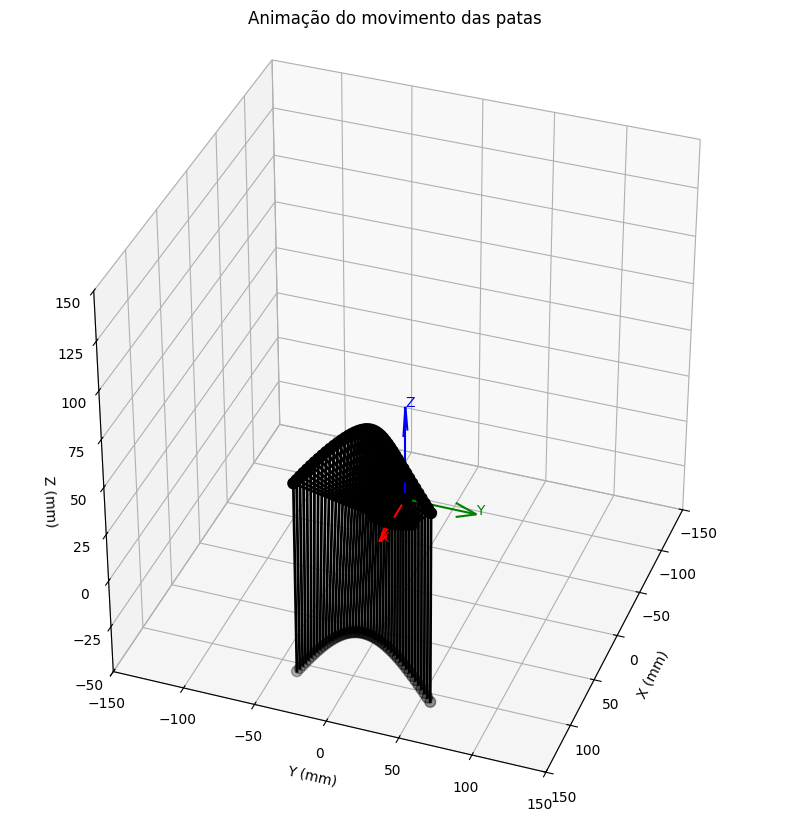

In [22]:
animar_patas(get_points(0, 30))

# Modelos de Marcha

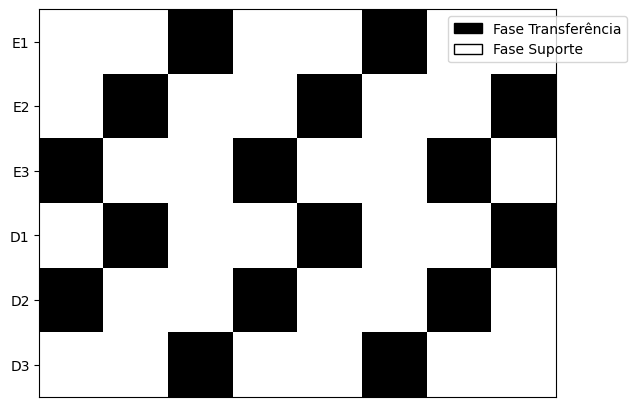

In [23]:
import matplotlib.pyplot as plt
import numpy as np

data = np.zeros((6, 8))

def marcha(marcha):
  if(marcha == 'tripode'):
    for j in range(8):
      for i in range(6):
          if i%2 == 0 and j%2 == 0:
            data[i, j] = 1
          elif i%2 == 1 and j%2 == 1:
            data[i, j] = 1
  elif(marcha=='wave'):
    for j in range(8):
      for i in range(6):
        if(j%6 == i):
          data[5-(i%6), j] = 1
  elif(marcha=='tetrapode'):
    for j in range(8):
      for i in range(6):
        if(j%3==0):
          data[2, j] = 1
          data[4, j] = 1
        elif(j%3==1):
          data[1, j] = 1
          data[3, j] = 1
        else:
          data[0, j] = 1
          data[5, j] = 1

#escolhe o tipo de marcha a ser representada
marcha('tetrapode')

fig, ax = plt.subplots()
im = ax.imshow(data, cmap='binary', vmin=0, vmax=1)

# Set eixo Y labels
y_labels = ['E1', 'E2', 'E3', 'D1', 'D2', 'D3']
ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels(y_labels)

ax.set_xticks([])

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='black', edgecolor='black', label='Fase Transferência'),
    Patch(facecolor='white', edgecolor='black', label='Fase Suporte')
]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()

plt.show()